<h1>Проверка Результатов A/B теста</h1>

<h3>VOLODYMYR CHUBAI</h3>
https://www.linkedin.com/in/volodymyr-chubai/

## Сценарий проекта
Я Junior Data Analyst, работаю в команде аналитиков данных. Наша компания по продаже различных аксессуаров решила изменить дизайн сайта. Руководство компании считает, что картинки с котиками нужно убрать с главной страницы сайта, а ее оформление сделать более нейтральным. В этой ситуации нужно проверить эффективность нового дизайна в сравнении со старым. Меня попросили сосредоточиться на данных о результе A/B-тестирования, проведенного веб-сайтом электронной коммерции. Моя главная цель будет заключаться в том, чтобы решить, будут ли изменения работать лучше для компании или нет.

## 2. PREPARE
### Источник данных
Используемые данные были взяты из следующего общедоступного набора данных: [A/B testing](https://www.kaggle.com/zhangluyuan/ab-testing) 

Данные общедоступны на Kaggle и хранятся в 1 CSV-файле.

### Собранные данные включают
`User ID` - Уникальный идентификатор пользователя.

`TimeStamp` - Время начала сеанса для пользователя.

`Group` - Содержит 2 разных значения в качестве контроля и обработки.

`Landing Page` - Содержит 2 разных значения как 'old_page' и 'new_page'.

`Converted` - Представляет поведение пользователя: совершил ли пользователь покупку (1) или нет (0).

## 3. PROCESS
### Подготовка рабочей среды
Я буду использовать Python для очистки, преобразования и визуализации данных. Установлены следующие библиотеки:

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

In [53]:
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint
import scipy.stats as stats
from math import ceil

### Импорт наборов данных

In [6]:
data = pd.read_csv('/Users/volodymyrchubay/Desktop/A.B testing/Kaggle projects/Checking A.B test results/ab_data.csv')

### Просмотр данных

In [8]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Проверка данных

In [9]:
data.shape

(294478, 5)

In [11]:
data.tail(2)

,user_id,timestamp,group,landing_page,converted
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [14]:
data.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [35]:
# проверка user ids на укикальность
data.shape[0]
data.user_id.nunique()

290584

In [38]:
print('Group info:')
data['group'].value_counts()

Group info:


treatment    147276
control      147202
Name: group, dtype: int64

In [40]:
print('Landing Page info:',)
data['landing_page'].value_counts()

Landing Page info:


old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [41]:
pd.crosstab(data['group'], data['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Ожидалось, что контрольная группа будет направлена на старую страницу, а экспериментальная группа - на новую. Группы отличаются по размеру, здесь что-то не так. Столбцы «group» и «landing_page» должны иметь одинаковый размер. Нужно избавится от записей, которые смущают нас.

### Очистка данных
Поиск нулевых значений

In [26]:
# количество отсутствующих данных в каждом столбце
data.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### Преобразование столбца 'timestamp' в datetime

In [27]:
data.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [29]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [30]:
data.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

### Преобразование столбца 'timestamp' в datetime

In [44]:
data['check_page'] = data['landing_page'].replace({'old_page':'control', 'new_page':'treatment'})
data[data['group'] != data['check_page']]

,user_id,timestamp,group,landing_page,converted,check_page
22,767017,2017-01-12 22:58:14.991443,control,new_page,0,treatment
240,733976,2017-01-11 15:11:16.407599,control,new_page,0,treatment
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0,control
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0,control
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0,control
...,...,...,...,...,...,...
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0,control
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0,treatment
294252,892498,2017-01-22 01:11:10.463211,treatment,old_page,0,control
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0,treatment


Возможно проблема в пользователях. Это нужно проверить

In [45]:
data = data.sort_values(by='timestamp')
data['user_id'].value_counts()

710039    2
867226    2
911040    2
926754    2
870710    2
         ..
917311    1
930737    1
630252    1
913465    1
920411    1
Name: user_id, Length: 290584, dtype: int64

Очень странно, одному пользователю показывалась одна и та же страница, но он был отнесен к разным группам. Другому пользователю были показаны другие страницы, но он был назначен в ту же группу. Если при А/Б тестировании одному пользователю показываются оба варианта, он должен принадлежать к разным группам, а если один вариант, то группа должна быть одна.

In [46]:
data[data['user_id'] == 805339]

,user_id,timestamp,group,landing_page,converted,check_page
90794,805339,2017-01-12 08:45:15.557052,treatment,old_page,0,control
234436,805339,2017-01-22 23:00:09.005288,control,old_page,0,control


In [47]:
data[data['user_id'] == 754884]

,user_id,timestamp,group,landing_page,converted,check_page
245524,754884,2017-01-17 23:46:45.624036,treatment,new_page,0,treatment
236842,754884,2017-01-18 20:10:48.538515,treatment,old_page,0,control


In [48]:
data[data['user_id'] == 722274]

,user_id,timestamp,group,landing_page,converted,check_page
262554,722274,2017-01-09 21:21:23.638444,control,new_page,0,treatment
105487,722274,2017-01-19 01:46:53.093257,control,old_page,0,control


Если убрать все несоответствия, исчезнут все повторяющиеся пользователи (кроме одного)

In [49]:
ab_data = data[data['group'] == data['check_page']]
ab_data['user_id'].value_counts()

773192    2
922696    1
829063    1
867327    1
762358    1
         ..
655980    1
861027    1
887897    1
924198    1
920411    1
Name: user_id, Length: 290584, dtype: int64

In [50]:
ab_data = ab_data.drop_duplicates(subset='user_id', keep='first')
ab_data['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [51]:
ab_data['group'].value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

## 4. ANALYSE
После обработки данных необходимо определить количество наблюдений, достаточное для проведения теста.

Как всегда, мы проверим нулевую гипотезу Hₒ, которая утверждает, что нет существенных различий между новой и старой страницами. Мы также проверим альтернативную гипотезу Hₐ, утверждающую, что различия существуют

Не вижу необходимости нарушать «золотой стандарт» и выбрал альфа = 0,05, мощность = 0,8. 

Функция ratio_effectsize вычисляет размер эффекта для теста, сравнивающего две пропорции. Коэффициент конверсии в настоящее время составляет 12%, с новой страницей мы ожидаем, что он увеличится на 2%. Нам нужно 4433 наблюдения для каждой группы

In [54]:
prop_effsize = sms.proportion_effectsize(0.12, 0.14)
alpha = 0.05
power = 0.8

required_n = sms.NormalIndPower().solve_power(
    prop_effsize,  
    alpha=alpha,
    power=power
    )
required_n = ceil(required_n)
required_n

4433

Или же можно использовать калькулятор Евана Миллера 'Sample Size Calculator', определив значения:
* Statistical power 1−β: 80%
* Significance level α: 5%
* Baseline conversion rate: 12%
* Minimum Detectable Effect: 2%

link: https://www.evanmiller.org/ab-testing/sample-size.html

In [56]:
# поместим необходимое количество наблюдений в отдельный фрейм данных
ab_required = pd.concat([ab_data[ab_data['group'] == 'control'].head(required_n),
                         ab_data[ab_data['group'] == 'treatment'].head(required_n)], ignore_index=True)

ab_required

,user_id,timestamp,group,landing_page,converted,check_page
0,781507,2017-01-02 13:42:15.234051,control,old_page,0,control
1,737319,2017-01-02 13:42:21.786186,control,old_page,0,control
2,799109,2017-01-02 13:42:45.219901,control,old_page,0,control
3,643921,2017-01-02 13:43:03.767329,control,old_page,1,control
4,677659,2017-01-02 13:43:32.744957,control,old_page,0,control
...,...,...,...,...,...,...
8861,816556,2017-01-03 05:39:04.377045,treatment,new_page,0,treatment
8862,706254,2017-01-03 05:39:46.805443,treatment,new_page,0,treatment
8863,872254,2017-01-03 05:40:18.166385,treatment,new_page,0,treatment
8864,832214,2017-01-03 05:40:27.946779,treatment,new_page,0,treatment


Чтобы оценить эффективность новой страницы, нам нужно рассчитать конверсию, стандартное отклонение и стандартную ошибку среднего значения для каждой группы. Основываясь на этих показателях будем делать вывод, относительно того, какая страница есть эффективней.

In [57]:
std_dev = lambda x: np.std(x, ddof=0)
std_err = lambda x: stats.sem(x, ddof=0)

conv_rates = ab_required.groupby('group')['converted']
conv_rates = conv_rates.agg([np.mean, std_dev, std_err])

conv_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conv_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.324,0.005
treatment,0.117,0.321,0.005


In [87]:
def plot_barplot(df, x_col, y_col, title, xlabel, ylabel):
    
    fig, ax = plt.subplots()
    ax.bar(df[x_col].index, df[y_col].values)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=90)
    
    # Добавляем текст на бары с форматированием числовых значений
    for i, val in enumerate(df[y_col]):
        plt.text(i, val, format(val, '.4f'), ha='center', va='bottom')
    
    
    plt.show()

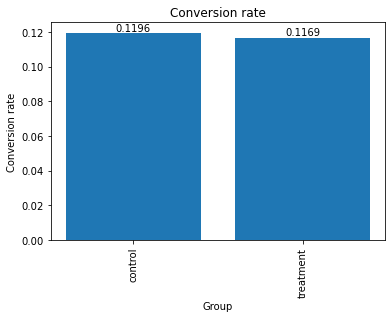

In [88]:
plot_barplot(conv_rates, 'conversion_rate', 'conversion_rate', 'Conversion rate', 'Group', 'Conversion rate')

Размер выборки большой, поэтому будет использоваться z-тест. Вычисленное значение p намного больше 0,05, что означает, что нулевая гипотеза не может быть отвергнута. Интересно, что наша теоретическая оценка 14% конверсии на новой странице даже не входит в доверительный интервал.

In [59]:
g_counts = [ab_required[ab_required['group'] == 'control']['converted'].sum(), 
            ab_required[ab_required['group'] == 'treatment']['converted'].sum()]
nobs = [required_n, required_n]

z_stat, pval = proportions_ztest(
    g_counts, 
    nobs=nobs
    )
ci_low, ci_upp = proportion_confint(
    g_counts, 
    nobs=nobs, 
    alpha=alpha
    )
print(f'z statistic: {z_stat:.3f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% Control group: [{ci_low[0]:.3f}, {ci_upp[0]:.3f}]')
print(f'ci 95% Reatment group: [{ci_low[1]:.3f}, {ci_upp[1]:.3f}]')

z statistic: 0.395
p-value: 0.693
ci 95% Control group: [0.110, 0.129]
ci 95% Reatment group: [0.107, 0.126]


## Вывод
Основываясь на статистических даных можно сказать что различий между новой и старой версиями страницы нет, ведь p-value > 0.05